In [1]:
import numpy as np  
from tqdm import tqdm
import matplotlib.pyplot as plt


NODATA, NOTPRESENT, MILD, SEVERE = -1, 0, 1, 2
DS_VALUES = [NOTPRESENT, MILD, SEVERE]
FALSE, TRUE = 0, 1

class EM():
    def __init__(self, P_DS, P_G, P_F_DS, P_D_DS, P_S_G_DS) -> None:
        # priors:
        self.P_DS = P_DS.copy()
        self.P_G = P_G.copy()
        self.P_F_DS = P_F_DS.copy()
        self.P_D_DS = P_D_DS.copy()
        self.P_S_G_DS = P_S_G_DS.copy()
    
    def randomize(self, delta):
        self.P_DS += np.random.uniform(0, delta, size=self.P_DS.shape)
        self.P_DS = self.P_DS / np.sum(self.P_DS)
        self.P_G += np.random.uniform(0, delta, size=self.P_G.shape)
        self.P_G = self.P_G / np.sum(self.P_G)
        self.P_F_DS += np.random.uniform(0, delta, size=self.P_F_DS.shape)
        self.P_F_DS /= np.sum(self.P_F_DS, axis=0, keepdims=True)
        self.P_D_DS += np.random.uniform(0, delta, size=self.P_D_DS.shape)
        self.P_D_DS /= np.sum(self.P_D_DS, axis=0, keepdims=True)
        self.P_S_G_DS += np.random.uniform(0, delta, size=self.P_S_G_DS.shape)
        self.P_S_G_DS /= np.sum(self.P_S_G_DS, axis=0, keepdims=True)


    def train(self, data):
        prev_weight = -1
        while TRUE:
            weights_over_data = np.zeros((len(data), len(DS_VALUES)))
            normalized_weights_over_data = np.zeros((len(data), len(DS_VALUES)))
            now_G = np.array([0.0,0.0])
            now_DS = np.array([0.0,0.0,0.0])
            now_G_DS = np.zeros(shape=(2, len(DS_VALUES)))
            now_F_DS = np.zeros((2, len(DS_VALUES)))
            now_D_DS = np.zeros(shape=(2, len(DS_VALUES)))
            now_S_G_DS = np.zeros(shape=(2, 2, len(DS_VALUES)))
            for index,  (s, f, d, g, ds) in enumerate(data):
                if ds != NODATA:
                    weights_over_data[index, ds] = 1
                    normalized_weights_over_data[index, ds] = 1
                else:
                    for ds_value in DS_VALUES:
                        weights_over_data[index, ds_value] = self.P_D_DS[d, ds_value] * self.P_F_DS[f, ds_value] * self.P_S_G_DS[s, g, ds_value] * self.P_G[g] * self.P_DS[ds_value]
                
                normalized_weights_over_data[index] = weights_over_data[index] / np.sum(weights_over_data[index])
                now_G[g] += np.sum(normalized_weights_over_data[index])
                now_DS += normalized_weights_over_data[index]
                now_G_DS[g] += normalized_weights_over_data[index]
                now_F_DS[f] += normalized_weights_over_data[index]
                now_D_DS[d] += normalized_weights_over_data[index]
                now_S_G_DS[s, g] += normalized_weights_over_data[index]
            
            total_weight = np.sum(weights_over_data)
            total_normalized_weight = np.sum(normalized_weights_over_data)

            if prev_weight != -1 and abs(total_weight - prev_weight) < 0.01:
                break
            prev_weight = total_weight
            # Update priors
            self.P_DS = now_DS / total_normalized_weight
            self.P_G = now_G / total_normalized_weight
            self.P_F_DS = now_F_DS / now_DS
            self.P_D_DS = now_D_DS / now_DS
            self.P_S_G_DS = now_S_G_DS / now_G_DS
    
    def predict(self, data):
        accuracy = 0
        for index,  (s, f, d, g, ds) in enumerate(data):
            weights = np.zeros(len(DS_VALUES))
            for ds_value in DS_VALUES:
                weights[ds_value] = self.P_D_DS[d, ds_value] * self.P_F_DS[f, ds_value] * self.P_S_G_DS[s, g, ds_value] * self.P_G[g] * self.P_DS[ds_value]
            pred = np.argmax(weights)
            if pred == ds:
                accuracy += 1
        return accuracy / len(data)

In [2]:
train_data = np.loadtxt(f"traindata.txt", delimiter=" ", usecols=range(1,6)).astype(dtype=int)
test_data = np.loadtxt(f"testdata.txt", delimiter=" ", usecols=range(1,6)).astype(dtype=int)

# Initialization
P_DS = np.zeros(len(DS_VALUES))
P_DS[NOTPRESENT] = 0.5
P_DS[MILD] = 0.25
P_DS[SEVERE] = 0.25

P_G = np.zeros(2)
P_G[FALSE] = 0.9
P_G[TRUE] = 0.1

P_F_DS = np.zeros((2, len(DS_VALUES)))
P_F_DS[TRUE, NOTPRESENT] = 0.01
P_F_DS[TRUE, MILD] = 0.95
P_F_DS[TRUE, SEVERE] = 0.25
P_F_DS[FALSE] = 1 - P_F_DS[TRUE]

P_D_DS = np.zeros((2, len(DS_VALUES)))
P_D_DS[TRUE, NOTPRESENT] = 0.01
P_D_DS[TRUE, MILD] = 0.3
P_D_DS[TRUE, SEVERE] = 0.95
P_D_DS[FALSE] = 1 - P_D_DS[TRUE]

P_S_G_DS = np.zeros((2, 2, len(DS_VALUES)))
P_S_G_DS[TRUE, TRUE, NOTPRESENT] = 0.01
P_S_G_DS[TRUE, TRUE, MILD] = 0.01
P_S_G_DS[TRUE, TRUE, SEVERE] = 0.01
P_S_G_DS[TRUE, FALSE, NOTPRESENT] = 0.02
P_S_G_DS[TRUE, FALSE, MILD] = 0.7
P_S_G_DS[TRUE, FALSE, SEVERE] = 0.7
P_S_G_DS[FALSE] = 1 - P_S_G_DS[TRUE]


In [3]:
TRIALS = 20
STEP = 0.1
plot_data_before_EM = []
plot_data = []
for delta in tqdm(np.arange(0, 4, STEP)):
    single_data_before_EM = [0 for _ in range(TRIALS)]
    single_data = [0 for _ in range(TRIALS)]
    for iter in range(TRIALS):
        model = EM(P_DS, P_G, P_F_DS, P_D_DS, P_S_G_DS)
        model.randomize(delta)
        single_data_before_EM[iter] = model.predict(test_data)
        model.train(train_data)
        single_data[iter] = model.predict(test_data)
    plot_data.append(single_data)
    plot_data_before_EM.append(single_data_before_EM)

 12%|█▎        | 5/40 [02:41<18:47, 32.22s/it]


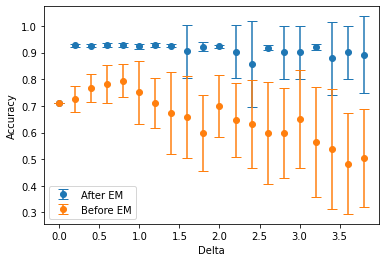

In [ ]:
x = np.arange(0, 4, STEP)
data = np.array(plot_data)
y = np.mean(data, axis=1)
err = np.std(data, axis=1)

data_before_EM = np.array(plot_data_before_EM)
y_before_EM = np.mean(data_before_EM, axis=1)
err_before_EM = np.std(data_before_EM, axis=1)
plt.errorbar(x, y, yerr=err, fmt='o', capsize=5)
plt.errorbar(x, y_before_EM, yerr=err_before_EM, fmt='o', capsize=5)
plt.ylabel("Accuracy")
plt.xlabel("Delta")
plt.legend(["After EM", "Before EM"], loc="lower left")
plt.title("Test Accuracy v.s Delta Value for Before and After EM")
plt.savefig("EM_accuracy.png")
plt.show()